In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
import pickle
from copy import deepcopy
from pathlib import Path

import gurobipy
from gurobipy import GRB
import dgl
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.problem import get_model, get_soc, load_instance, get_feasible
from src.dataset import InstanceEarlyFixingDataset
from src.net import InstanceGCN
from src.utils import load_from_wandb

In [3]:
from torcheval.metrics.functional import binary_f1_score, binary_accuracy

In [5]:
def create_batch(g, xs):
    g_batch = list()
    for x in xs:
        g_ = deepcopy(g)
        curr_feats = g_.nodes['var'].data['x']
        g_.nodes['var'].data['x'] = torch.hstack((
            # unsqueeze features dimension, if necessary
            curr_feats.view(curr_feats.shape[0],-1),
            x.view(x.shape[-1],-1),
        ))
        g_batch.append(g_)
    return dgl.batch(g_batch)

def get_ef_accuracy(g_batch, xs, x_opt, net, name=None, plot=True):
    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch))

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution
    err = (x_hat - x_opt).abs()

    thresholds = [.01, .02, .05, .1, .2, .5]

    accs = list()
    f1s = list()
    ns = list()
    for thresh in thresholds:
        most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) >= 1 - thresh)
        if most_certain.sum() == 0:
            accs.append(1)
            f1s.append(1)
            ns.append(0)
            continue
        fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_opt)
        fixed_x_opt = x_opt[most_certain]

        # acc = (fixed_x_hat == fixed_x_opt).sum() / fixed_x_opt.shape[0]
        acc = binary_accuracy(fixed_x_hat, fixed_x_opt)
        f1 = binary_f1_score(fixed_x_hat, fixed_x_opt)

        accs.append(acc)
        f1s.append(f1)
        ns.append(fixed_x_hat.shape[0])

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, accs, '.-', label='Accuracy')
        ax.plot(ns, f1s, '.-', label='F1')
        ax.set_xlim((0, x_opt.shape[0]))
        ax.set_ylim((.5, 1.))
        ax.grid()
        ax.legend()

        ax.set_title('Early fixing accuracy '+str(name))
        ax.set_xlabel('# fixed variables')
        # ax.set_ylabel('score')

        for i, thresh in enumerate(thresholds):
            ax.annotate(thresh, (ns[i], accs[i]))

        fig.show()
    
    return thresholds, ns, accs, f1s

def get_ef_times(g_batch, xs, instance, net, name=None, plot=True, timeout=60):
    if isinstance(instance, str) or isinstance(instance, Path):
        instance = load_instance(instance)

    jobs = list(range(instance['jobs'][0]))
    model = get_model(jobs, instance, coupling=True, new_ineq=True, timeout=timeout)
    # model.setParam('BestObjStop', obj)
    model.update()

    vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

    # baseline results
    model_ = model.copy()
    model_.optimize()
    baseline_runtime = model_.Runtime
    baseline_obj = model_.ObjVal
    baseline_gap = model_.MIPGap

    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch))

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution

    thresholds = [0., .01, .02, .05, .1, .2, .5]
    # thresholds = [0., .01, .02, .05, .1]

    runtimes = list()
    objs = list()
    gaps = list()
    ns = list()
    for thresh in thresholds:
        most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) > 1 - thresh)

        if most_certain.sum() == 0:
            runtimes.append(baseline_runtime)
            objs.append(baseline_obj)
            gaps.append(baseline_gap)
            ns.append(0)
            continue

        fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_hat)

        fixed_vars_names = vars_names[most_certain]

        # fix variables
        model_ = model.copy()
        for fixed_var_name, fixed_var_X in zip(fixed_vars_names, fixed_x_hat):
            model_.getVarByName(fixed_var_name).lb = fixed_var_X
            model_.getVarByName(fixed_var_name).ub = fixed_var_X

        model_.update()
        model_.optimize()

        if model_.status == 3:
            break

        runtimes.append(model_.Runtime)
        objs.append(model_.ObjVal)
        gaps.append(model_.MIPGap)
        ns.append(fixed_x_hat.shape[0])

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, runtimes, '.-', label='Runtime')
        # ax.set_xlim((0, x_opt.shape[0]))
        ax.grid()
        ax.legend(loc=1)

        ax.set_title('Early fixing performance '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('Runtime')

        obj_ax = ax.twinx()
        obj_ax.plot(ns, objs, '.-', c='r', label='Objectives')
        obj_ax.legend(loc=4)
        obj_ax.set_ylabel('Objective')

        for i, n in enumerate(ns):
            ax.annotate(thresholds[i], (n, runtimes[i]))

        fig.show()

    return thresholds, ns, runtimes, objs, gaps

In [6]:
instances_dir = Path('../data/raw')
instances = list(instances_dir.glob('97_9*.jl'))  # test instances only
# instances = sorted(instances)
# instances = instances[-2:]
instances = [instances_dir/'97_9_9.jl', instances_dir/'97_9_6.jl']

with open('../97_9_opts.pkl', 'rb') as f:
    opts = pickle.load(f)

net = InstanceGCN(
    2,
    n_passes=1,
    single_conv_for_both_passes=False,
    n_h_feats=19,
    conv1='GraphConv',
    conv2='SAGEConv',
    conv2_kwargs={
        'aggregator_type': 'pool',
        'feat_drop': .09088,
    },
    conv3='GraphConv',
    readout_op=None,
)
net = load_from_wandb(net, 'arrf20uc', 'sat-gnn', 'model_last')
net.eval()

objs = [opts[i.name]['obj'] for i in instances]
opts = [opts[i.name]['sol'] for i in instances]
ds = InstanceEarlyFixingDataset(
    [load_instance(i) for i in instances],
    opts,
    samples_per_problem=1,
)
g1 = ds.gs[0]
g2 = ds.gs[1]

x1_opt = torch.from_numpy(opts[0])
x2_opt = torch.from_numpy(opts[1])

g1, g2

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


(Graph(num_nodes={'con': 5830, 'soc': 291, 'var': 1746},
       num_edges={('con', 'c2s', 'soc'): 775, ('con', 'c2v', 'var'): 57875, ('soc', 's2c', 'con'): 775, ('var', 'v2c', 'con'): 57875},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 Graph(num_nodes={'con': 5929, 'soc': 291, 'var': 1746},
       num_edges={('con', 'c2s', 'soc'): 775, ('con', 'c2v', 'var'): 55565, ('soc', 's2c', 'con'): 775, ('var', 'v2c', 'con'): 55565},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]))

In [9]:
x1s = torch.randint(0, 2, (100, 1746))
g1_batch = create_batch(g1, x1s)

x2s = torch.randint(0, 2, (100, 1746))
g2_batch = create_batch(g2, x2s)

g1_batch, g2_batch

(Graph(num_nodes={'con': 583000, 'soc': 29100, 'var': 174600},
       num_edges={('con', 'c2s', 'soc'): 77500, ('con', 'c2v', 'var'): 5787500, ('soc', 's2c', 'con'): 77500, ('var', 'v2c', 'con'): 5787500},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 Graph(num_nodes={'con': 592900, 'soc': 29100, 'var': 174600},
       num_edges={('con', 'c2s', 'soc'): 77500, ('con', 'c2v', 'var'): 5556500, ('soc', 's2c', 'con'): 77500, ('var', 'v2c', 'con'): 5556500},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]))

[0, 145, 792, 921, 1117, 1746] [1, tensor(0.9793, dtype=torch.float64), tensor(0.9634, dtype=torch.float64), tensor(0.9305, dtype=torch.float64), tensor(0.9078, dtype=torch.float64), tensor(0.8259, dtype=torch.float64)] [1, tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0.4921, dtype=torch.float64), tensor(0.7696, dtype=torch.float64), tensor(0.7148, dtype=torch.float64)]


[0, 165, 827, 861, 1117, 1746] [1, tensor(1., dtype=torch.float64), tensor(0.9698, dtype=torch.float64), tensor(0.9698, dtype=torch.float64), tensor(0.9678, dtype=torch.float64), tensor(0.8803, dtype=torch.float64)] [1, tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0.9077, dtype=torch.float64), tensor(0.7977, dtype=torch.float64)]


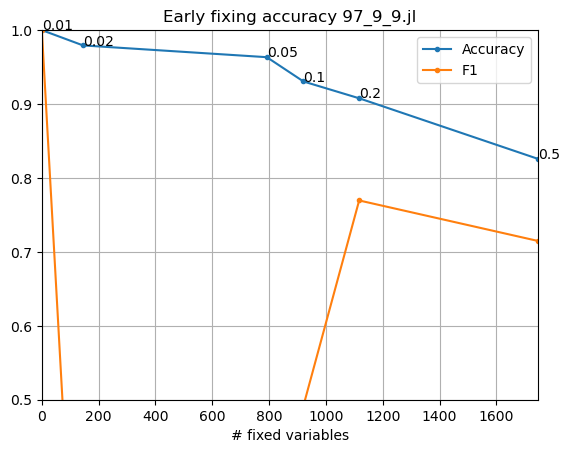

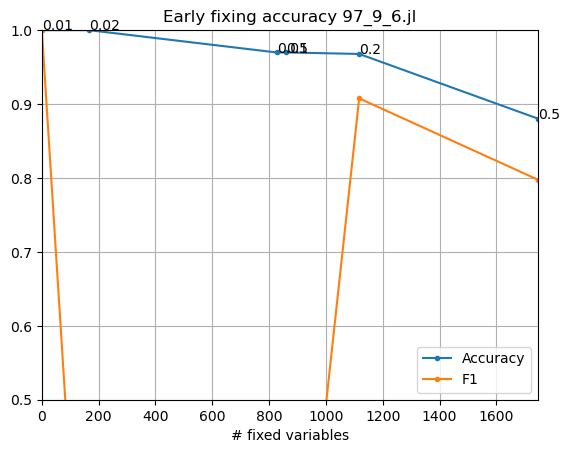

In [10]:
_, n1s, acc1s, f11s = get_ef_accuracy(g1_batch, x1s, x1_opt, net, name=instances[0].name)
print(n1s, acc1s, f11s)
_, n2s, acc2s, f12s = get_ef_accuracy(g2_batch, x2s, x2_opt, net, name=instances[1].name)
print(n2s, acc2s, f12s)

### Early Fixing Time Reduction

([0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
 [0, 0, 145],
 [2.371066093444824, 2.371066093444824, 3.7080078125],
 [2783.0, 2783.0, 2776.0],
 [0.0, 0.0, 0.0])

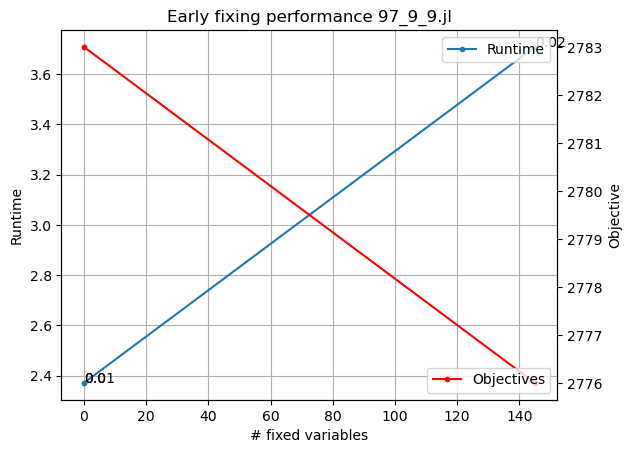

In [11]:
get_ef_times(g1_batch, x1s, instances[0], net, name=instances[0].name, timeout=None)

([0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
 [0, 0, 165],
 [0.958406925201416, 0.958406925201416, 0.811607837677002],
 [3126.0, 3126.0, 3126.0],
 [0.0, 0.0, 0.0])

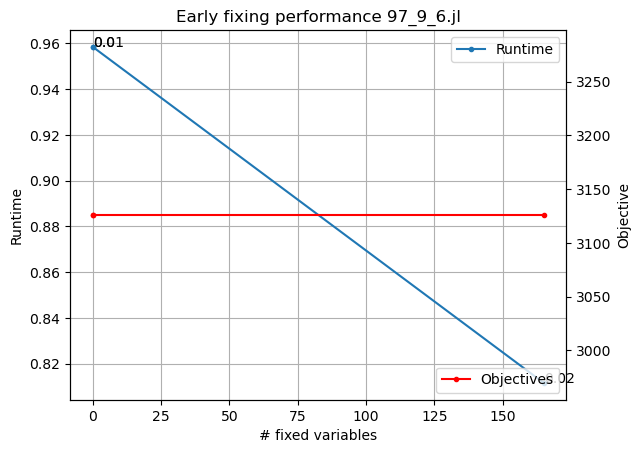

In [12]:
get_ef_times(g2_batch, x2s, instances[1], net, name=instances[1].name, timeout=None)

### Fixing by # of variables

In [13]:
def get_ef_accuracy_n_vars(g_batch, xs, x_opt, net, name=None, plot=True):
    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch))

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs().mean(0)  # prob. of the predicted optimal solution

    most_certain_idx  = (x_hat - 0.5).abs().sort(descending=True).indices

    ns = np.logspace(0,np.log(x_opt.shape[0])/np.log(10)).astype(int)
    ns = np.unique(ns)

    accs = list()
    for n in ns:
        if n == 0:
            accs.append(1)
            continue

        fixed_x_hat = (x_hat[most_certain_idx[:n]] > .5).to(x_opt)
        fixed_x_opt = x_opt[most_certain_idx[:n]]

        accs.append((fixed_x_hat == fixed_x_opt).sum() / fixed_x_opt.shape[0])

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, accs, '.-', label='Threshold')
        ax.set_xlim((0, x_opt.shape[0]))
        ax.set_ylim((.5, 1.))
        ax.grid()
        ax.legend()

        ax.set_title('Early fixing accuracy '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('accuracy')

        fig.show()
    
    return ns, accs

def get_ef_times_n_vars(g_batch, xs, x_opt, instance, net, name=None, plot=True, timeout=60):
    if isinstance(instance, str) or isinstance(instance, Path):
        instance = load_instance(instance)

    jobs = list(range(instance['jobs'][0]))
    model = get_model(jobs, instance, coupling=True, new_ineq=True, timeout=timeout)
    # model.setParam('BestObjStop', obj)
    model.update()

    vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

    # baseline results
    model_ = model.copy()
    model_.optimize()
    baseline_runtime = model_.Runtime
    baseline_obj = model_.ObjVal
    baseline_gap = model_.MIPGap

    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch))

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs().mean(0)  # prob. of the predicted optimal solution

    most_certain_idx  = (x_hat - 0.5).abs().sort(descending=True).indices


    runtimes = list()
    objs = list()
    accs = list()
    gaps = list()
    ns = list()
    for n in [0, 50, 100, 150, 200, 300, 500, 1000, len(x_hat)]:
        if n == 0:
            runtimes.append(baseline_runtime)
            objs.append(baseline_obj)
            gaps.append(baseline_gap)
            ns.append(n)
            accs.append(100)
            continue

        fixed_x_hat = (x_hat[most_certain_idx[:n]] > .5).to(x_hat)
        fixed_x_opt = x_opt[most_certain_idx[:n]]
        fixed_vars_names = vars_names[most_certain_idx[:n]]

        # fix variables
        model_ = model.copy()
        for fixed_var_name, fixed_var_X in zip(fixed_vars_names, fixed_x_hat):
            model_.getVarByName(fixed_var_name).lb = fixed_var_X
            model_.getVarByName(fixed_var_name).ub = fixed_var_X

        model_.update()
        model_.optimize()

        if model_.status != 2:
            break

        runtimes.append(model_.Runtime)
        objs.append(model_.ObjVal)
        accs.append(100 * (fixed_x_hat == fixed_x_opt).sum() / fixed_x_opt.shape[0])
        gaps.append(model_.MIPGap)
        ns.append(n)

    objs = [100 * o / max(objs) for o in objs]

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, runtimes, '.-', label='Runtime')
        # ax.set_xlim((0, x_opt.shape[0]))
        ax.grid()
        ax.legend(loc=1)

        ax.set_title('Early fixing performance '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('Runtime')

        ax.set_xlim(0,max(ns))

        obj_ax = ax.twinx()
        obj_ax.plot(ns, objs, '.-', c='r', label='Objective')
        obj_ax.plot(ns, accs, '.-', c='g', label='Accuracy')
        obj_ax.legend(loc=4)
        obj_ax.set_ylim(min(objs + accs), 100)
        obj_ax.set_ylabel('Objective')

        fig.show()

    return ns, runtimes, objs, gaps

In [14]:
x1s = torch.randint(0, 2, (200, 1746))
g1_batch = create_batch(g1, x1s)

x2s = torch.randint(0, 2, (200, 1746))
g2_batch = create_batch(g2, x2s)

g1_batch, g2_batch

(Graph(num_nodes={'con': 1166000, 'soc': 58200, 'var': 349200},
       num_edges={('con', 'c2s', 'soc'): 155000, ('con', 'c2v', 'var'): 11575000, ('soc', 's2c', 'con'): 155000, ('var', 'v2c', 'con'): 11575000},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 Graph(num_nodes={'con': 1185800, 'soc': 58200, 'var': 349200},
       num_edges={('con', 'c2s', 'soc'): 155000, ('con', 'c2v', 'var'): 11113000, ('soc', 's2c', 'con'): 155000, ('var', 'v2c', 'con'): 11113000},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]))

[   1    2    3    4    5    6    7    8    9   11   13   15   18   21
   24   28   33   38   45   52   61   71   82   96  112  130  152  177
  206  240  280  326  380  443  516  601  699  815  949 1105 1287 1499
 1745] [tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.9859), tensor(0.9878), tensor(0.9792), tensor(0.9821), tensor(0.9769), tensor(0.9803), tensor(0.9831), tensor(0.9757), tensor(0.9708), tensor(0.9679), tensor(0.9724), tensor(0.9711), tensor(0.9684), tensor(0.9632), tensor(0.9651), tensor(0.9657), tensor(0.9644), tensor(0.9273), tensor(0.9077), tensor(0.8881), tensor(0.8672), tensor(0.8252)]
[   1    2    3    4    5    6    7    8    9   11   13   15   18   21
   24   28   33   38   45   52   61   71   82   96  112  130  152  177
  206  240  280  326  380  443  5

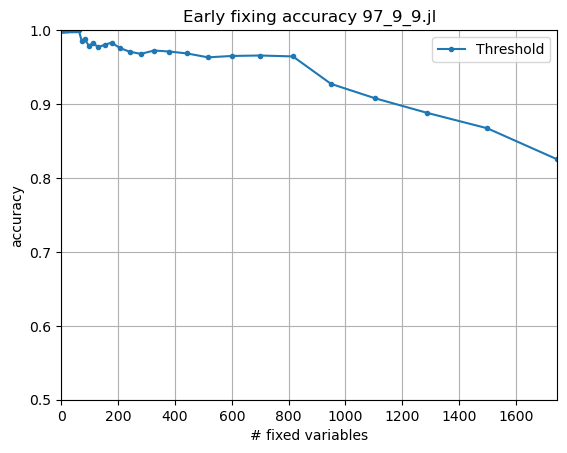

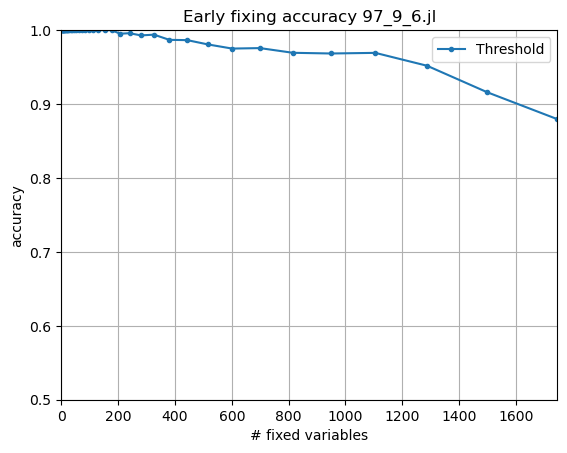

In [15]:
n1s, acc1s = get_ef_accuracy_n_vars(g1_batch, x1s, x1_opt, net, name=instances[0].name)
print(n1s, acc1s)
n2s, acc2s = get_ef_accuracy_n_vars(g2_batch, x2s, x2_opt, net, name=instances[1].name)
print(n2s, acc2s)

([0, 50, 100, 150, 200],
 [2.363957166671753,
  1.2282500267028809,
  2.873682975769043,
  2.0872268676757812,
  1.7767658233642578],
 [100.0, 100.0, 99.8203377650018, 99.74847287100252, 99.74847287100252],
 [0.0, 0.0, 0.0, 0.0, 0.0])

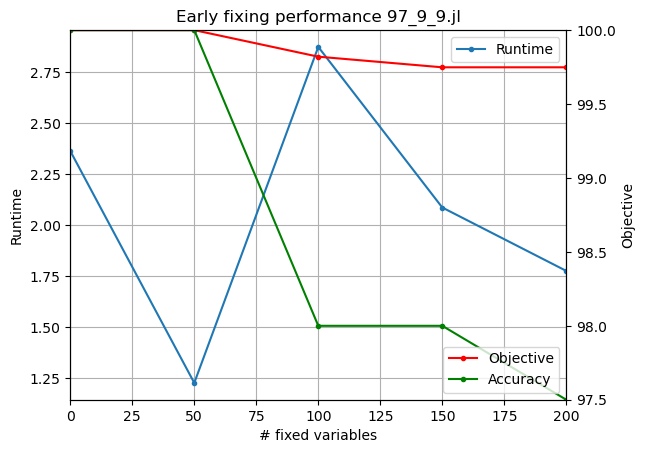

In [16]:
get_ef_times_n_vars(g1_batch, x1s, x1_opt, instances[0], net, name=instances[0].name, timeout=60)

/tmp/ipykernel_3082391/3861142762.py:123: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  obj_ax.set_ylim(min(objs + accs), 100)


([0, 50, 100, 150],
 [0.926353931427002,
  0.8606278896331787,
  0.7683150768280029,
  0.728456974029541],
 [100.0, 100.0, 100.0, 100.0],
 [0.0, 0.0, 0.0, 0.0])

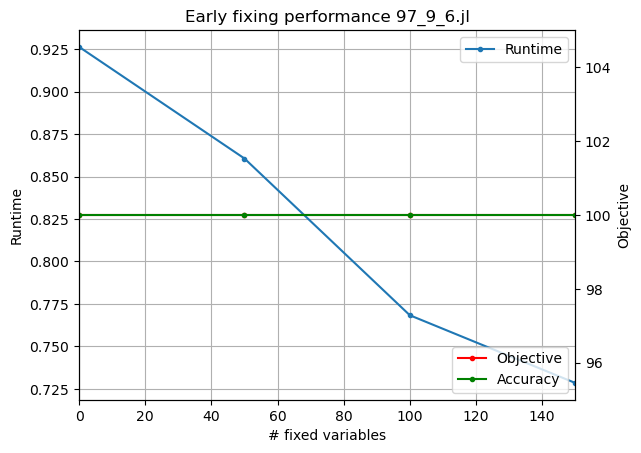

In [17]:
get_ef_times_n_vars(g2_batch, x2s, x2_opt, instances[1], net, name=instances[1].name, timeout=300)

In [18]:
with torch.no_grad():
    y_hat = torch.sigmoid(net(g1_batch))

y_flip = 1 - y_hat
x_hat = (x1s - y_flip).abs().mean(0)  # prob. of the predicted optimal solution

# Is early fixing in Gurobi done right?

In [14]:
# model = get_model(list(range(9)), instances[0], coupling=True)
# model.optimize()
print(model.Runtime)

model_vars = [v for v in model.getVars() if ('x(' in v.VarName) or ('phi(' in v.VarName)]

11.946637868881226


In [7]:
for n in [0,1,5,10,50]:
    efd_model = get_model(list(range(9)), instances[0], coupling=True)

    model_vars = [v for v in efd_model.getVars() if ('x(' in v.VarName) or ('phi(' in v.VarName)]
    for i in range(n):
        model_vars[i].ub = opts[0][i]
        model_vars[i].lb = opts[0][i]

    efd_model.optimize()
    print(n, 'fixed => runtime =', efd_model.Runtime, 'seconds')

0 fixed => runtime = 11.862847805023193 seconds
1 fixed => runtime = 11.81365704536438 seconds
5 fixed => runtime = 14.2623929977417 seconds
10 fixed => runtime = 10.928970098495483 seconds
50 fixed => runtime = 10.781934022903442 seconds


In [6]:
model = get_model(list(range(9)), instances[0], coupling=True)
model_vars = [v for v in model.getVars() if ('x(' in v.VarName) or ('phi(' in v.VarName)]

for n in [0,1,5,10,50]:
    x_fix = dict()
    phi_fix = dict()
    for i in range(n):
        v_name = model_vars[i].VarName
        j, t = v_name.split('(')[1][:-1].split(',')
        j = int(j)
        t = int(t)
        if 'x(' in v_name:
            x_fix[(j,t)] = opts[0][i]
        elif 'phi(' in v_name:
            phi_fix[(j,t)] = opts[0][i]

    efd_model = get_model(list(range(9)), instances[0], coupling=True, x_fix=x_fix, phi_fix=phi_fix)

    efd_model.optimize()
    print(n, 'fixed => runtime =', efd_model.Runtime, 'seconds')

0 fixed => runtime = 11.908422946929932 seconds
1 fixed => runtime = 11.557680130004883 seconds
5 fixed => runtime = 12.90221905708313 seconds
10 fixed => runtime = 9.564600944519043 seconds
50 fixed => runtime = 11.287322998046875 seconds


In [ ]:
for n in [0,1,5,10,50]:
    efd_model = get_model(list(range(9)), instances[0], coupling=True)

    model_vars = [v for v in efd_model.getVars() if ('x(' in v.VarName) or ('phi(' in v.VarName)]
    for i in range(n):
        model_vars[-i].ub = opts[0][-i]
        model_vars[-i].lb = opts[0][-i]

    efd_model.optimize()
    print(n, 'fixed => runtime =', efd_model.Runtime, 'seconds')

0 fixed => runtime = 12.271695852279663 seconds
1 fixed => runtime = 11.89828085899353 seconds
5 fixed => runtime = 10.406981945037842 seconds
10 fixed => runtime = 8.838873863220215 seconds
50 fixed => runtime = 8.784255027770996 seconds


In [8]:
for n in [0,1,5,10,50]:
    efd_model = get_model(list(range(9)), instances[0], coupling=True)

    model_vars = [v for v in efd_model.getVars() if ('x(' in v.VarName) or ('phi(' in v.VarName)]
    for i in range(n):
        model_vars[-i].ub = opts[0][-i]
        model_vars[-i].lb = opts[0][-i]

    efd_model.optimize()
    print(n, 'fixed => runtime =', efd_model.Runtime, 'seconds')

0 fixed => runtime = 12.271695852279663 seconds
1 fixed => runtime = 11.89828085899353 seconds
5 fixed => runtime = 10.406981945037842 seconds
10 fixed => runtime = 8.838873863220215 seconds
50 fixed => runtime = 8.784255027770996 seconds


In [13]:
model = get_model(list(range(9)), instances[0], coupling=True)
model_vars = [v for v in model.getVars() if ('x(' in v.VarName) or ('phi(' in v.VarName)]

for n in [0,1,5,10,50]:
    x_fix = dict()
    phi_fix = dict()
    for i in range(n):
        v_name = model_vars[-i].VarName
        j, t = v_name.split('(')[1][:-1].split(',')
        j = int(j)
        t = int(t)
        if 'x(' in v_name:
            x_fix[(j,t)] = opts[0][-i]
        elif 'phi(' in v_name:
            phi_fix[(j,t)] = opts[0][-i]

    efd_model = get_model(list(range(9)), instances[0], coupling=True, x_fix=x_fix, phi_fix=phi_fix)

    efd_model.optimize()
    print(n, 'fixed => runtime =', efd_model.Runtime, 'seconds')

0 fixed => runtime = 11.987212896347046 seconds


GurobiError: Constraint has no bool value (are you trying "lb <= expr <= ub"?)

In [31]:
x_fix

{(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (0, 4): 0.0}

In [16]:
len(model_vars)

1746

In [39]:
g_batch = g1_batch
xs = x1s

instance = load_instance(instances[0])
jobs = list(range(instance['jobs'][0]))
model = get_model(jobs, instance, coupling=True, new_ineq=False)
model.setParam('MIPGap', .05)
model.update()

vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

with torch.no_grad():
    y_hat = torch.sigmoid(net(g_batch))

y_flip = 1 - y_hat
x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution

thresholds = [0., .01, .02, .05, .1, .2, .5]
# thresholds = [0., .01, .02, .05, .1]

runtimes = list()
objs = list()
ns = list()
thresh = .02

most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) > 1 - thresh)

fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_hat)

fixed_x_hat

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)

In [42]:
for var_name in vars_names:
    var = var_name.split('(')[0]
    j, t = var_name.split('(')[1][:-1].split(',')
    j = int(j)
    t = int(t)

    if var
    break

0,0


In [48]:
vars_names.reshape((9,194)).shape

(9, 194)

In [49]:
len(vars_names) == 9 * 194

True

In [57]:
from src.problem import get_feasible

x_candidate = x_hat.mean(0).numpy().reshape((9, 194))
x_feasible = get_feasible(model, x_candidate, instance)

x_feasible

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
from src.problem import get_feasible

x_feasible = get_feasible(model, x_hat.mean(0).numpy().reshape((9, 194)), instance, weighted=True)
x_cand = (x_hat.mean(0) > .5).to(x_hat)
x_cand_feas = x_feasible.flatten()

In [71]:
x_cand.shape

torch.Size([1746])

In [72]:
x_cand_feas.shape

(1746,)

In [75]:
feas_mask = x_cand.numpy() == x_cand_feas
feas_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [79]:
most_certain.numpy() * feas_mask

array([False, False, False, ...,  True, False, False])

([0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
 [0, 0, 47],
 [2.3700289726257324, 2.3700289726257324, 2.8245890140533447],
 [2785.0, 2785.0, 2786.0])

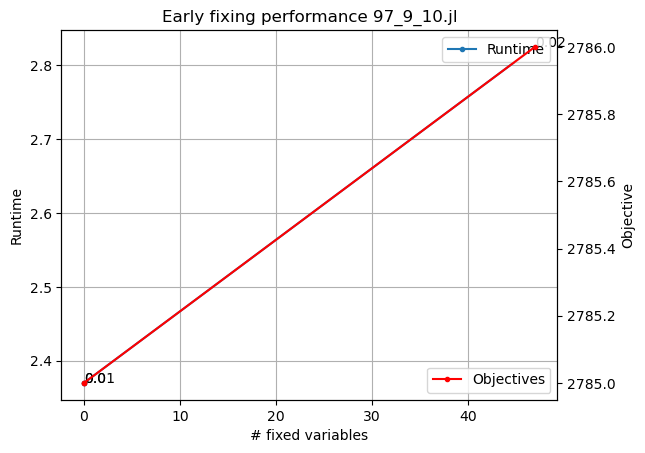

In [6]:
def get_ef_feas_times(g_batch, xs, instance, name=None, plot=True, gap=.05):
    if isinstance(instance, str) or isinstance(instance, Path):
        instance = load_instance(instance)

    jobs = list(range(instance['jobs'][0]))
    model = get_model(jobs, instance, coupling=True, new_ineq=False)
    model.setParam('MIPGap', gap)
    model.update()

    vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
    vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

    # baseline results
    model_ = model.copy()
    model_.optimize()
    baseline_runtime = model_.Runtime
    baseline_obj = model_.ObjVal

    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch)).numpy()

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs().mean(0).numpy()  # prob. of the predicted optimal solution

    # feasibility recovery
    x_feasible = get_feasible(model, x_hat.reshape((9, 194)), instance, weighted=True)
    x_cand = (x_hat > .5).astype(int)
    x_cand_feas = x_feasible.flatten()
    feas_mask = x_cand == x_cand_feas

    thresholds = [0., .01, .02, .05, .1, .2, .5]
    # thresholds = [0., .01, .02, .05, .1]

    runtimes = list()
    objs = list()
    ns = list()
    for thresh in thresholds:
        most_certain = (x_hat < thresh) | (x_hat > 1 - thresh)
        most_certain *= feas_mask  # only most certain that were not changed for feasibility

        if most_certain.sum() == 0:
            runtimes.append(baseline_runtime)
            objs.append(baseline_obj)
            ns.append(0)
            continue

        fixed_x_hat = (x_hat[most_certain] > .5).astype(int)

        fixed_vars_names = vars_names[most_certain]

        # fix variables
        model_ = model.copy()
        for fixed_var_name, fixed_var_X in zip(fixed_vars_names, fixed_x_hat):
            model_.getVarByName(fixed_var_name).lb = fixed_var_X
            model_.getVarByName(fixed_var_name).ub = fixed_var_X

        model_.update()
        model_.optimize()

        if model_.status == 3:
            break

        runtimes.append(model_.Runtime)
        objs.append(model_.ObjVal)
        ns.append(fixed_x_hat.shape[0])

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, runtimes, '.-', label='Runtime')
        # ax.set_xlim((0, x_opt.shape[0]))
        ax.grid()
        ax.legend(loc=1)

        ax.set_title('Early fixing performance '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('Runtime')

        obj_ax = ax.twinx()
        obj_ax.plot(ns, objs, '.-', c='r', label='Objectives')
        obj_ax.legend(loc=4)
        obj_ax.set_ylabel('Objective')

        for i, n in enumerate(ns):
            ax.annotate(thresholds[i], (n, runtimes[i]))

        fig.show()

    return thresholds, ns, runtimes, objs

get_ef_feas_times(g1_batch, x1s, instances[0], name=instances[0].name)

([0.0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5],
 [0, 0, 35],
 [50.43629693984985, 50.43629693984985, 47.224790811538696],
 [3064.0, 3064.0, 3064.0])

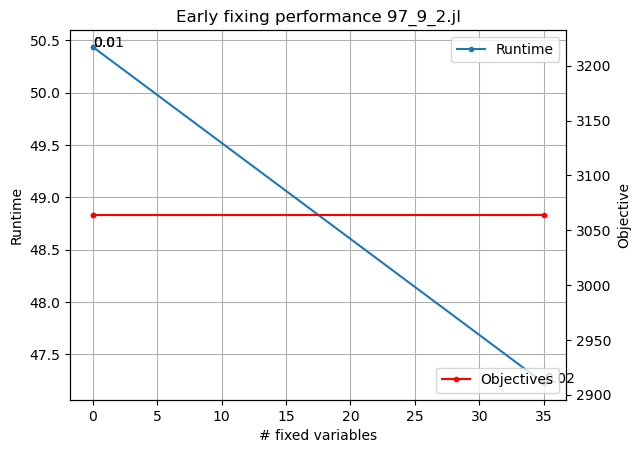

In [7]:
get_ef_feas_times(g2_batch, x2s, instances[1], name=instances[1].name)

# OOD Generalization

## instance 97_11

In [17]:
instances_dir = Path('../data/raw')
instances = [instances_dir/'97_11_15.jl']

with open('../97_11_opts.pkl', 'rb') as f:
    opts = pickle.load(f)

opts = [opts[i.name]['sol'] for i in instances]
ds = InstanceEarlyFixingDataset(
    [load_instance(i) for i in instances],
    opts,
    samples_per_problem=10,
)

g11 = ds.gs[0]

x11_opt = [torch.from_numpy(opt) for opt in opts][0]

g11

Graph(num_nodes={'con': 7074, 'soc': 291, 'var': 2134},
      num_edges={('con', 'c2s', 'soc'): 775, ('con', 'c2v', 'var'): 72438, ('soc', 's2c', 'con'): 775, ('var', 'v2c', 'con'): 72438},
      metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')])

In [19]:
x11 = torch.randint(0, 2, (200, 2134))
g11_batch = create_batch(g11, x11)
g11_batch

Graph(num_nodes={'con': 1414800, 'soc': 58200, 'var': 426800},
      num_edges={('con', 'c2s', 'soc'): 155000, ('con', 'c2v', 'var'): 14487600, ('soc', 's2c', 'con'): 155000, ('var', 'v2c', 'con'): 14487600},
      metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')])

(array([   1,    2,    3,    4,    5,    6,    7,    8,   10,   12,   14,
          16,   19,   22,   26,   31,   36,   42,   49,   58,   68,   79,
          93,  109,  127,  149,  174,  204,  238,  279,  326,  381,  446,
         522,  610,  713,  834,  976, 1141, 1334, 1560, 1824, 2133]),
 [tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.9167),
  tensor(0.9286),
  tensor(0.9375),
  tensor(0.9474),
  tensor(0.9545),
  tensor(0.9615),
  tensor(0.9677),
  tensor(0.9722),
  tensor(0.9762),
  tensor(0.9796),
  tensor(0.9828),
  tensor(0.9853),
  tensor(0.9873),
  tensor(0.9892),
  tensor(0.9908),
  tensor(0.9921),
  tensor(0.9933),
  tensor(0.9943),
  tensor(0.9951),
  tensor(0.9958),
  tensor(0.9928),
  tensor(0.9939),
  tensor(0.9921),
  tensor(0.9910),
  tensor(0.9904),
  tensor(0.9852),
  tensor(0.9832),
  tensor(0.9796),
  tensor(0.9744),
  tensor(0.9290),
  tensor(0.8396),
  tensor(0.8288),
  tens

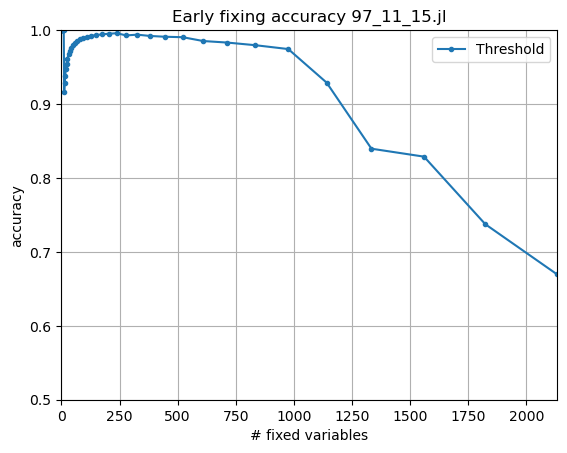

In [20]:
get_ef_accuracy_n_vars(g11_batch, x11, x11_opt, net, name=instances[0].name)

([0, 50, 100, 150, 200, 300],
 [3.641613006591797,
  4.218171834945679,
  3.1671440601348877,
  4.054460048675537,
  3.5157201290130615,
  2.5597147941589355],
 [100.0, 100.0, 100.0, 100.0, 100.0, 99.54062589721505],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

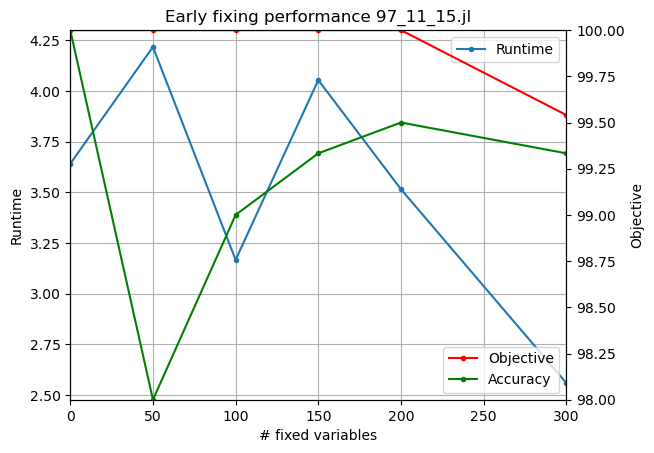

In [21]:
get_ef_times_n_vars(g11_batch, x11, x11_opt, instances[0], net, name=instances[0].name, timeout=10*60)

## instance 120_9

In [17]:
instances_dir = Path('../data/raw')
instances = [instances_dir/'120_9.jl']

with open('../120_9_opts.pkl', 'rb') as f:
    opts = pickle.load(f)

opts = [opts[i.name]['sol'] for i in instances]
ds = InstanceEarlyFixingDataset(
    [load_instance(i) for i in instances],
    opts,
    samples_per_problem=10,
)

g120 = ds.gs[0]

x120_opt = [torch.from_numpy(opt) for opt in opts][0]

g120

Graph(num_nodes={'con': 6646, 'soc': 360, 'var': 2160},
      num_edges={('con', 'c2s', 'soc'): 959, ('con', 'c2v', 'var'): 65765, ('soc', 's2c', 'con'): 959, ('var', 'v2c', 'con'): 65765},
      metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')])

In [18]:
x120 = torch.randint(0, 2, (200, 2160))
g120_batch = create_batch(g120, x120)
g120_batch

Graph(num_nodes={'con': 1329200, 'soc': 72000, 'var': 432000},
      num_edges={('con', 'c2s', 'soc'): 191800, ('con', 'c2v', 'var'): 13153000, ('soc', 's2c', 'con'): 191800, ('var', 'v2c', 'con'): 13153000},
      metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')])

(array([   1,    2,    3,    4,    5,    6,    7,    8,   10,   12,   14,
          16,   19,   22,   26,   31,   36,   42,   50,   58,   68,   80,
          94,  110,  128,  150,  176,  205,  240,  281,  329,  385,  450,
         527,  616,  721,  843,  986, 1154, 1349, 1578, 1846, 2159]),
 [tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(1.),
  tensor(0.9722),
  tensor(0.9762),
  tensor(0.9600),
  tensor(0.9655),
  tensor(0.9706),
  tensor(0.9500),
  tensor(0.9574),
  tensor(0.9636),
  tensor(0.9688),
  tensor(0.9733),
  tensor(0.9773),
  tensor(0.9756),
  tensor(0.9750),
  tensor(0.9751),
  tensor(0.9666),
  tensor(0.9688),
  tensor(0.9689),
  tensor(0.9677),
  tensor(0.9708),
  tensor(0.9750),
  tensor(0.9763),
  tensor(0.9777),
  tensor(0.9099),
  tensor(0.8769),
  tensor(0.8213),
  tensor(0.7757),
  tensor(0.7087)

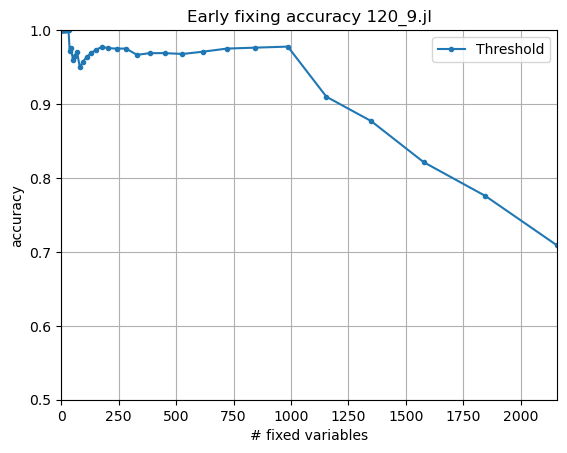

In [19]:
get_ef_accuracy_n_vars(g120_batch, x120, x120_opt, net, name=instances[0].name)

([0, 50, 100, 150, 200, 300],
 [1.6219868659973145,
  0.6922740936279297,
  0.7645528316497803,
  0.6766259670257568,
  0.6708810329437256,
  0.8047549724578857],
 [100.0,
  100.0,
  99.91243432574431,
  99.91243432574431,
  99.86865148861646,
  99.08056042031524],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

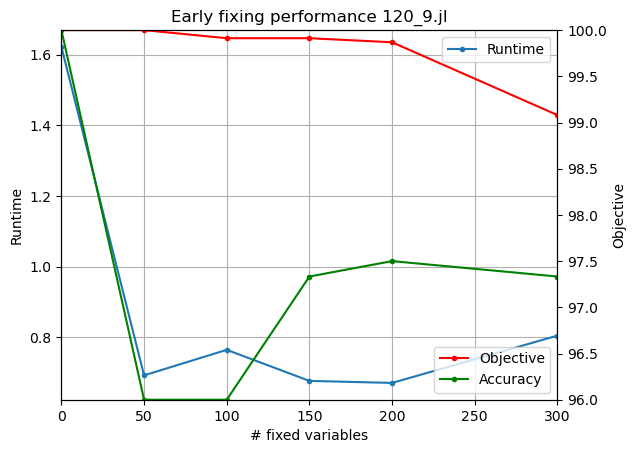

In [20]:
get_ef_times_n_vars(g120_batch, x120, x120_opt, instances[0], net, name=instances[0].name, timeout=120)